In [1]:
"""
Learning to optimize parametric Quadratic Programming (pQP)
problems using Neuromancer.

Problem formulation pQP:
    minimize     x^2 + y^2
    subject to
               -x - y + p1 <= 0,
               x + y - p1 - 1 <= 0,
               x - y + p2 - 1 <= 0,
               -x + y - p2 <= 0
"""



'\nLearning to optimize parametric Quadratic Programming (pQP)\nproblems using Neuromancer.\n\nProblem formulation pQP:\n    minimize     x^2 + y^2\n    subject to\n               -x - y + p1 <= 0,\n               x + y - p1 - 1 <= 0,\n               x - y + p2 - 1 <= 0,\n               -x + y - p2 <= 0\n'

In [1]:
import cvxpy as cp
import numpy as np
import time
import torch
import torch.nn as nn
import neuromancer.slim as slim
import matplotlib.pyplot as plt
import matplotlib.patheffects as patheffects

from neuromancer.trainer import Trainer
from neuromancer.problem import Problem
from neuromancer.constraint import variable
from neuromancer.dataset import DictDataset
from neuromancer.loss import PenaltyLoss
from neuromancer.modules import blocks
from neuromancer.system import Node


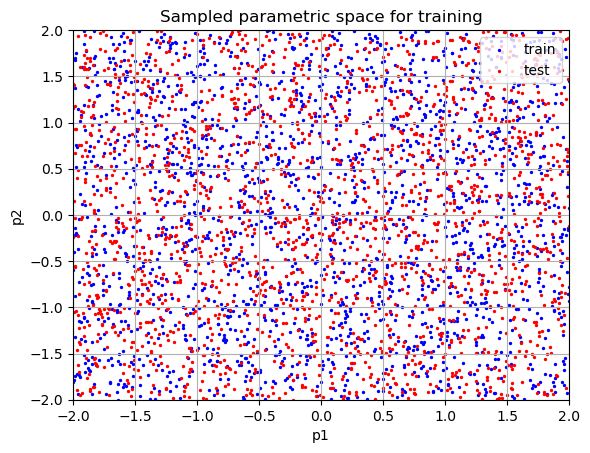

In [2]:

"""
# # #  Dataset
"""
data_seed = 408
np.random.seed(data_seed)
nsim = 2000 # number of datapoints: increase sample density for more robust results
# create dictionaries with sampled datapoints with uniform distribution
p_low, p_high = -2.0, 2.0
samples_train = {"p1": torch.FloatTensor(nsim, 1).uniform_(p_low, p_high),
                    "p2": torch.FloatTensor(nsim, 1).uniform_(p_low, p_high)}
samples_dev = {"p1": torch.FloatTensor(nsim, 1).uniform_(p_low, p_high),
                "p2": torch.FloatTensor(nsim, 1).uniform_(p_low, p_high)}
samples_test = {"p1": torch.FloatTensor(nsim, 1).uniform_(p_low, p_high),
                "p2": torch.FloatTensor(nsim, 1).uniform_(p_low, p_high)}
# create named dictionary datasets
train_data = DictDataset(samples_train, name='train')
dev_data = DictDataset(samples_dev, name='dev')
test_data = DictDataset(samples_test, name='test')
# create torch dataloaders for the Trainer
train_loader = torch.utils.data.DataLoader(train_data, batch_size=100, num_workers=0,
                                            collate_fn=train_data.collate_fn, shuffle=True)
dev_loader = torch.utils.data.DataLoader(dev_data, batch_size=100, num_workers=0,
                                            collate_fn=dev_data.collate_fn, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=100, num_workers=0,
                                            collate_fn=test_data.collate_fn, shuffle=True)
# note: training quality will depend on the DataLoader parameters such as batch size and shuffle

# visualize taining and test samples for 2D parametric space
a_train = samples_train['p1'].numpy()
p_train = samples_train['p2'].numpy()
a_dev = samples_dev['p1'].numpy()
p_dev = samples_dev['p2'].numpy()
plt.figure()
plt.scatter(a_train, p_train, s=2., c='blue', marker='o')
plt.scatter(a_dev, p_dev, s=2., c='red', marker='o')
plt.title('Sampled parametric space for training')
plt.xlim(p_low, p_high)
plt.ylim(p_low, p_high)
plt.grid(True)
plt.xlabel('p1')
plt.ylabel('p2')
plt.legend(['train', 'test'], loc='upper right')
plt.show()
plt.show(block=True)


In [3]:

"""
# # #  pQP primal solution map architecture
"""
# define neural architecture for the solution map
func = blocks.MLP(insize=2, outsize=2,
                bias=True,
                linear_map=slim.maps['linear'],
                nonlin=nn.ReLU,
                hsizes=[80] * 4)
# define symbolic solution map with concatenated features (problem parameters)
xi = lambda p1, p2: torch.cat([p1, p2], dim=-1)
features = Node(xi, ['p1', 'p2'], ['xi'], name='features')
sol_map = Node(func, ['xi'], ['x'], name='map')
# trainable components of the problem solution
components = [features, sol_map]
"""
# # #  mpQP objective and constraints formulation in Neuromancer
"""
# variables
x = variable("x")[:, [0]]
y = variable("x")[:, [1]]
# sampled parameters
p1 = variable('p1')
p2 = variable('p2')
# objective function
f = x ** 2 + y ** 2
obj = f.minimize(weight=1.0, name='obj')
objectives = [obj]
# constraints
Q_con = 100.
g1 = -x - y + p1
con_1 = Q_con * (g1 <= 0)
con_1.name = 'c1'
g2 = x + y - p1 - 1
con_2 = Q_con*(g2 <= 0)
con_2.name = 'c2'
g3 = x - y + p2 - 1
con_3 = Q_con*(g3 <= 0)
con_3.name = 'c3'
g4 = -x + y - p2
con_4 = Q_con*(g4 <= 0)
con_4.name = 'c4'
constraints = [con_1, con_2, con_3, con_4]
"""
# # #  pQP problem formulation in Neuromancer
"""
# create penalty method loss function
loss = PenaltyLoss(objectives, constraints)
# construct constrained optimization problem
problem = Problem(components, loss)


In [4]:

"""
# # #  pQP problem solution in Neuromancer
"""
optimizer = torch.optim.AdamW(problem.parameters(), lr=1e-3)
# define trainer
trainer = Trainer(
    problem,
    train_loader,
    dev_loader,
    test_loader,
    optimizer,
    epochs=100,
    patience=200,
    warmup=100,
    train_metric="train_loss",
    dev_metric="dev_loss",
    test_metric="test_loss",
    eval_metric="dev_loss",
)

# Train solution map
best_model = trainer.train()



epoch: 0  train_loss: 77.96682739257812
epoch: 1  train_loss: 3.340695858001709
epoch: 2  train_loss: 1.3312404155731201
epoch: 3  train_loss: 1.2560259103775024
epoch: 4  train_loss: 1.1257810592651367
epoch: 5  train_loss: 1.153852105140686
epoch: 6  train_loss: 1.0973807573318481
epoch: 7  train_loss: 1.082202434539795
epoch: 8  train_loss: 1.2101091146469116
epoch: 9  train_loss: 1.186422348022461
epoch: 10  train_loss: 1.0904903411865234
epoch: 11  train_loss: 1.0077948570251465
epoch: 12  train_loss: 1.0820857286453247
epoch: 13  train_loss: 1.1564885377883911
epoch: 14  train_loss: 1.149672269821167
epoch: 15  train_loss: 1.020477056503296
epoch: 16  train_loss: 1.0418879985809326
epoch: 17  train_loss: 1.0619009733200073
epoch: 18  train_loss: 1.0854787826538086
epoch: 19  train_loss: 1.1598427295684814
epoch: 20  train_loss: 1.0666736364364624
epoch: 21  train_loss: 1.0997858047485352
epoch: 22  train_loss: 1.179548978805542
epoch: 23  train_loss: 1.1041109561920166
epoch: 24 

In [5]:

'''
#######################################
#######################################

Add on a DR correction layer

#######################################
########################################
'''
import DRSolver as dr
from importlib import reload
reload(dr)
'''
# DEFINE THE OBJECTIVE
'''
def f_obj(x,parms):
    return torch.pow( x[0] ,2) + torch.pow( x[1], 2)
'''
# DEFINE THE CONSTRAINTS
'''
def F_ineq(x,parms):
    c_1 = -x[0] - x[1] + parms[0]
    c_2 = x[0] + x[1] - parms[0] - 1 
    c_3 = x[0] - x[1] + parms[1] - 1 
    c_4 = -x[0] + x[1] - parms[1]
    return torch.stack((c_1,c_2,c_3,c_4))
num_steps = 10 # number of DR iterations to take
initial_steps = 0
x_dim = 2 # dimension of primal variable
n_ineq = 4 #number of inequality constraints
parm_dim = 2 #number of problem parameters
order = 'second' # What order approximation of the objective to use {'first', 'second'}
project_fixedpt = False
#metric scaling parameters
initial_lb_P = 1e-6
initial_ub_P = 1e6
lb_P = 1.0/5.0
ub_P = 5.0
scl_lb_P = 0.05
scl_ub_P = 1.0
solver = dr.DRSolver(
    f_obj = f_obj, 
    F_ineq = F_ineq,
    x_dim = x_dim, 
    n_ineq = n_ineq, 
    order = order,
    JF_fixed=True,
    parm_dim = parm_dim,
    num_steps = num_steps,
    initial_steps= initial_steps,
    initial_lb_P=initial_lb_P,
    initial_ub_P = initial_ub_P,
    lb_P = lb_P,
    ub_P = ub_P,
    scl_lb_P = scl_lb_P,
    scl_ub_P = scl_ub_P,
    project_fixedpt=project_fixedpt
    )
# REMAP THROUGH DR CORRECTION
sol_map = Node(func, ['xi'], ['x_predicted'], name='map')
DR_correction = Node(solver,['x_predicted','xi'],['x','cnv_gap','x_history'])
components = [features, sol_map, DR_correction]
### ADD A CONVERGENCE PENALTY
cnv_gap = variable("cnv_gap")
f_cnv = (cnv_gap)**2
cnv_obj = f_cnv.minimize(weight=1e8, name='cnv_obj')
objectives = [cnv_obj]
constraints = []
# create loss function
loss = PenaltyLoss(objectives, constraints)
# construct constrained optimization problem
problem = Problem(components, loss)



In [6]:

'''
#######################################
#######################################

Train DR correction layer

#######################################
########################################
'''
optimizer = torch.optim.AdamW(solver.parameters(), lr=1e-2)
# define trainer
trainer = Trainer(
    problem,
    train_loader,
    dev_loader,
    test_loader,
    optimizer,
    epochs=100,
    patience=200,
    warmup=100,
    train_metric="train_loss",
    dev_metric="dev_loss",
    test_metric="test_loss",
    eval_metric="dev_loss",
)
# Train solution map
best_model = trainer.train()



epoch: 0  train_loss: 2020.649169921875
epoch: 1  train_loss: 15.388501167297363
epoch: 2  train_loss: 0.5998567342758179
epoch: 3  train_loss: 0.28741055727005005
epoch: 4  train_loss: 0.22093789279460907
epoch: 5  train_loss: 0.19557051360607147
epoch: 6  train_loss: 0.180402934551239
epoch: 7  train_loss: 0.16996519267559052
epoch: 8  train_loss: 0.15844962000846863
epoch: 9  train_loss: 0.1497335135936737
epoch: 10  train_loss: 0.14415186643600464
epoch: 11  train_loss: 0.13672932982444763
epoch: 12  train_loss: 0.13370394706726074
epoch: 13  train_loss: 0.127488911151886
epoch: 14  train_loss: 0.12530645728111267
epoch: 15  train_loss: 0.12039396911859512
epoch: 16  train_loss: 0.11739090830087662
epoch: 17  train_loss: 0.11516620218753815
epoch: 18  train_loss: 0.11082659661769867
epoch: 19  train_loss: 0.10786019265651703
epoch: 20  train_loss: 0.10924471914768219
epoch: 21  train_loss: 0.10437331348657608
epoch: 22  train_loss: 0.10340514034032822
epoch: 23  train_loss: 0.10035

In [7]:
solver.num_steps = 10

In [25]:
plt.rcParams.update({'font.size': 14})

In [30]:
import matplotlib as mpl

/var/folders/5t/0jpw47ds3rs3_fzmw9fk919w0000gn/T/ipykernel_73005/3438776095.py:46: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cp_plot = ax[row_id, column_id].contourf(xx, yy, J, 50, alpha=0.4,cmap = mpl.colormaps['bone'],linewidth = 10)
/var/folders/5t/0jpw47ds3rs3_fzmw9fk919w0000gn/T/ipykernel_73005/3438776095.py:57: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  plt.setp(cg1.collections,
/var/folders/5t/0jpw47ds3rs3_fzmw9fk919w0000gn/T/ipykernel_73005/3438776095.py:59: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  plt.setp(cg2.collections,
/var/folders/5t/0jpw47ds3rs3_fzmw9fk919w0000gn/T/ipykernel_73005/3438776095.py:61: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  plt.setp(cg3.collect

primal solution x=[0.5], y=[-0.75]
parameter p=(-1.25, -1.25)
primal solution Neuromancer x1=0.5000192523002625, x2=-0.7500033378601074
primal solution x=[0.5], y=[-0.5]
parameter p=(-1.0, -1.0)
primal solution Neuromancer x1=0.4998820126056671, x2=-0.500083863735199
primal solution x=[0.25], y=[-0.25]
parameter p=(-0.5, -0.5)
primal solution Neuromancer x1=0.2499827891588211, x2=-0.2499946802854538
primal solution x=[0.125], y=[-0.125]
parameter p=(-0.25, -0.25)
primal solution Neuromancer x1=0.12496775388717651, x2=-0.12498101592063904
primal solution x=[0.], y=[0.]
parameter p=(0.0, 0.0)
primal solution Neuromancer x1=0.0001678764820098877, x2=1.1585652828216553e-06
primal solution x=[0.125], y=[0.125]
parameter p=(0.25, 0.25)
primal solution Neuromancer x1=0.12498199939727783, x2=0.1250239908695221
primal solution x=[0.25], y=[0.25]
parameter p=(0.5, 0.5)
primal solution Neuromancer x1=0.249977245926857, x2=0.24998687207698822
primal solution x=[0.5], y=[0.5]
parameter p=(1.0, 1.0)

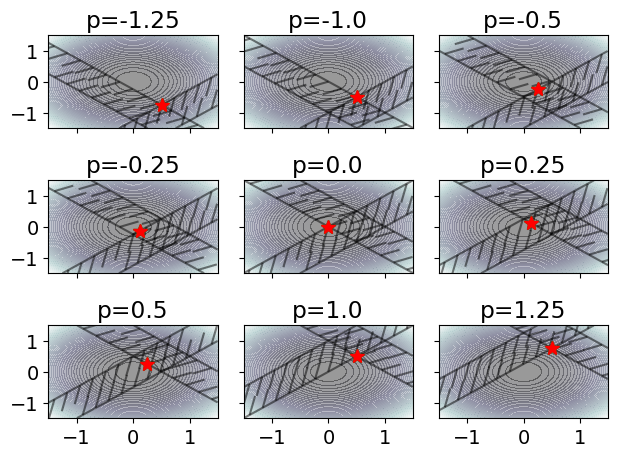

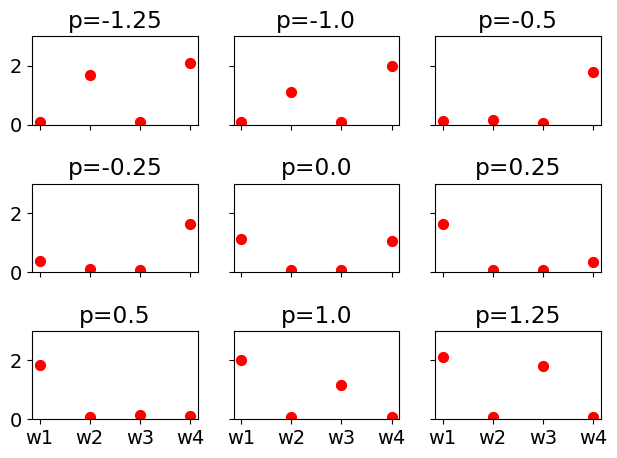

Solution for 2000 problems via solver obtained in 12.6810 seconds
Solver mean constraints violation 0.0000
Solver mean objective value 0.7830

Neuromancer mean constraints violation no DR 0.0004
Neuromancer mean objective value no DR 1.0603
MSE primal optimizers no DR: 0.04546198777983705
mean objective value discrepancy np DR: 35.42 % 

Solution for 2000 problems via Neuromancer obtained in 0.0350 seconds
Neuromancer mean constraints violation 0.0000
Neuromancer mean objective value 0.7830
Solution speedup factor 362.0549
MSE primal optimizers: 1.310690054263699e-09
mean objective value discrepancy: 0.00 %


In [49]:


'''
#######################################
#######################################

Compare to CVXPY Solver

#######################################
########################################
'''


"""
CVXPY benchmarks
"""
# Define the CVXPY problems.

def QP_param(p1, p2):
    x = cp.Variable(1)
    y = cp.Variable(1)
    prob = cp.Problem(cp.Minimize(x ** 2 + y ** 2),
                        [-x - y + p1 <= 0,
                        x + y - p1 - 1 <= 0,
                        x - y + p2 - 1 <= 0,
                        -x + y - p2 <= 0])
    return prob, x, y


"""
Plots
"""
# test problem parameters
params = [-1.25, -1.0, -0.5, -0.25, 0.0, 0.25, 0.5, 1.0, 1.25]
x1 = np.arange(-1.5, 1.5, 0.01)
y1 = np.arange(-1.5, 1.5, 0.01)
xx, yy = np.meshgrid(x1, y1)
fig, ax = plt.subplots(3,3,sharex = True,sharey=True)
row_id = 0
column_id = 0
for i, p in enumerate(params):
    if i % 3 == 0 and i != 0:
        row_id += 1
        column_id = 0

    # eval and plot objective and constraints
    J = xx ** 2 + yy ** 2
    cp_plot = ax[row_id, column_id].contourf(xx, yy, J, 50, alpha=0.4,cmap = mpl.colormaps['bone'],linewidth = 10)
    ax[row_id, column_id].set_title(f'p={p}')

    c1 = xx + yy - p
    c2 = -xx - yy + p + 1
    c3 = -xx + yy - p + 1
    c4 = xx - yy + p
    cg1 = ax[row_id, column_id].contour(xx, yy, c1, [0], colors='k', alpha=0.5)
    cg2 = ax[row_id, column_id].contour(xx, yy, c2, [0], colors='k', alpha=0.5)
    cg3 = ax[row_id, column_id].contour(xx, yy, c3, [0], colors='k', alpha=0.5)
    cg4 = ax[row_id, column_id].contour(xx, yy, c4, [0], colors='k', alpha=0.5)
    plt.setp(cg1.collections,
                path_effects=[patheffects.withTickedStroke()], alpha=0.5)
    plt.setp(cg2.collections,
                path_effects=[patheffects.withTickedStroke()], alpha=0.5)
    plt.setp(cg3.collections,
                path_effects=[patheffects.withTickedStroke()], alpha=0.5)
    plt.setp(cg4.collections,
                path_effects=[patheffects.withTickedStroke()], alpha=0.5)

    #fig.colorbar(cp_plot, ax=ax[row_id,column_id])

    # Solve CVXPY problem
    
    prob, x, y = QP_param(p, p)
    
    prob.solve()

    # Solve via neuromancer
    datapoint = {'p1': torch.tensor([[p]]), 'p2': torch.tensor([[p]]),
                    'name': 'test'}
    model_out = problem(datapoint)
    x_nm = model_out['test_' + "x"][0, 0].detach().numpy()
    y_nm = model_out['test_' + "x"][0, 1].detach().numpy()

    print(f'primal solution x={x.value}, y={y.value}')
    print(f'parameter p={p, p}')
    print(f'primal solution Neuromancer x1={x_nm}, x2={y_nm}')
    #print(f' f: {model_out["test_" + f.key]}')
    #print(f' g1: {model_out["test_" + g1.key]}')
    #print(f' g2: {model_out["test_" + g2.key]}')

    #print(f' g3: {model_out["test_" + g3.key]}')
    #print(f' g4: {model_out["test_" + g4.key]}')

    # Plot optimal solutions
    ax[row_id, column_id].plot(x.value, y.value, 'g*', markersize=10)
    ax[row_id, column_id].plot(x_nm, y_nm, 'r*', markersize=10)
    column_id += 1
fig.tight_layout()
plt.show()
plt.show(block=True)
plt.interactive(False)


fig, ax = plt.subplots(3,3,sharex = True,sharey=True)
row_id = 0
column_id = 0
for i, p in enumerate(params):
    if i % 3 == 0 and i != 0:
        row_id += 1
        column_id = 0

    test_p = torch.tensor([p,p],dtype=torch.float32)
    P_vals = solver.Pm_2('',test_p)
    idxs = 0.1*np.arange(0,len(P_vals)-2,1)
    ax[row_id, column_id].scatter(idxs,torch.diag(P_vals)[2:].detach().numpy(),s = 50, c='r')
    ax[row_id, column_id].set_ylim(0,3)
    ax[row_id, column_id].set_xticks(idxs)
    ax[row_id, column_id].set_xticklabels(['w1','w2','w3','w4'])
    ax[row_id, column_id].set_title(f'p={p}')

    column_id += 1
fig.tight_layout()
plt.show()
plt.show(block=True)
plt.interactive(False)

"""
Benchmark Solution
"""

def eval_constraints(x, y, p1, p2):
    """
    evaluate mean constraints violations
    """
    con_1_viol = np.maximum(0, -x - y + p1)
    con_2_viol = np.maximum(0, x + y - p1 - 1)
    con_3_viol = np.maximum(0, x - y + p2 - 1)
    con_4_viol = np.maximum(0, -x + y - p2)
    con_viol = con_1_viol + con_2_viol + con_3_viol + con_4_viol
    con_viol_mean = np.mean(con_viol)
    return con_viol_mean
    #return [con_1_viol,con_2_viol,con_3_viol,con_4_viol]

def eval_objective(x, y, a1=1, a2=1):
    obj_value_mean = np.mean(a1 * x**2 + a2 * y**2)
    return obj_value_mean

# Solve via neuromancer
with torch.no_grad():
    t = time.time()
    samples_test['name'] = 'test'
    model_out = problem(samples_test)
    nm_time = time.time() - t

x_nm = model_out['test_' + "x"][:, [0]].detach().numpy()
y_nm = model_out['test_' + "x"][:, [1]].detach().numpy()


x_nm_noDR = model_out['test_x_predicted'][:, [0]].detach().numpy()
y_nm_noDR = model_out['test_x_predicted'][:, [1]].detach().numpy()


# Solve via solver
t = time.time()
x_solver, y_solver = [], []
for i in range(0, nsim):
    p1 = samples_test['p1'][i].detach().numpy()
    p2 = samples_test['p2'][i].detach().numpy()
    prob, x, y = QP_param(p1, p2)
    prob.solve(solver='ECOS_BB', verbose=False)
    prob.solve()
    x_solver.append(x.value)
    y_solver.append(y.value)
solver_time = time.time() - t

x_solver = np.asarray(x_solver)
y_solver = np.asarray(y_solver)

p1_vec = samples_test['p1'].detach().numpy()
p2_vec = samples_test['p2'].detach().numpy()


# Evaluate solver solution
print(f'Solution for {nsim} problems via solver obtained in {solver_time:.4f} seconds')
solver_con_viol_mean = eval_constraints(x_solver, y_solver, p1_vec, p2_vec)
print(f'Solver mean constraints violation {solver_con_viol_mean:.4f}')
solver_obj_mean = eval_objective(x_solver, y_solver)
print(f'Solver mean objective value {solver_obj_mean:.4f}\n')




# Evaluate neuromancer solution no DR
nm_con_viol_mean = eval_constraints(x_nm_noDR, y_nm_noDR, p1_vec, p2_vec)
print(f'Neuromancer mean constraints violation no DR {nm_con_viol_mean:.4f}')
nm_obj_mean = eval_objective(x_nm_noDR, y_nm_noDR)
print(f'Neuromancer mean objective value no DR {nm_obj_mean:.4f}')

# Difference in primal optimizers
dx = (x_solver - x_nm_noDR)[:,0]
dy = (y_solver - y_nm_noDR)[:,0]
err_x = np.mean(dx**2)
err_y = np.mean(dy**2)
err_primal = err_x + err_y
print('MSE primal optimizers no DR:', err_primal)

# Difference in objective
err_obj = np.abs(solver_obj_mean - nm_obj_mean) / solver_obj_mean * 100
print(f'mean objective value discrepancy np DR: {err_obj:.2f} % \n')



# Evaluate neuromancer solution
print(f'Solution for {nsim} problems via Neuromancer obtained in {nm_time:.4f} seconds')
nm_con_viol_mean = eval_constraints(x_nm, y_nm, p1_vec, p2_vec)
print(f'Neuromancer mean constraints violation {nm_con_viol_mean:.4f}')
nm_obj_mean = eval_objective(x_nm, y_nm)
print(f'Neuromancer mean objective value {nm_obj_mean:.4f}')


# neuromancer solver comparison
speedup_factor = solver_time/nm_time
print(f'Solution speedup factor {speedup_factor:.4f}')

# Difference in primal optimizers0
dx = (x_solver - x_nm)[:,0]
dy = (y_solver - y_nm)[:,0]
err_x = np.mean(dx**2)
err_y = np.mean(dy**2)
err_primal = err_x + err_y
err_primal = np.mean((dx**2 + dy**2))
rel_err_primal = np.mean((dx**2 + dy**2))/np.mean((x_solver**2 + y_solver**2 ))
print('MSE primal optimizers:', rel_err_primal)

# Difference in objective
err_obj = np.abs(solver_obj_mean - nm_obj_mean) / solver_obj_mean * 100
print(f'mean objective value discrepancy: {err_obj:.2f} %')




In [9]:

p1_vec = samples_test['p1'].detach().numpy()
p2_vec = samples_test['p2'].detach().numpy()

In [10]:
def constraint_resids(x, y, p1, p2):
    """
    evaluate mean constraints violations
    """
    con_1_v = -x - y + p1
    con_2_v =  x + y - p1 - 1
    con_3_v =  x - y + p2 - 1
    con_4_v = -x + y - p2
    con_v = np.concatenate([con_1_v,con_2_v,con_3_v, con_4_v],axis=1)
    return con_v


cr = constraint_resids(x_nm, y_nm, p1_vec, p2_vec)

P_v_list = []
for i in range(p1_vec.shape[0]):
    test_p = torch.tensor([p1_vec[i,0],p2_vec[i,0]],dtype=torch.float32)
    P_vals = solver.Pm_2('',test_p)
    P_v_list.append(torch.diag(P_vals)[2:].detach().numpy())
    
pv = np.stack(P_v_list)

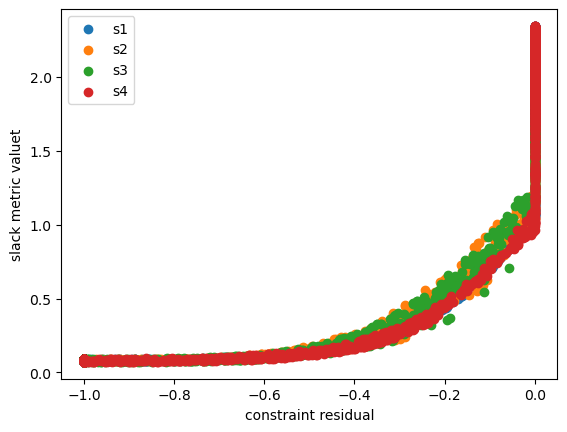

In [11]:

plt.scatter(cr[:,0],pv[:,0])
plt.scatter(cr[:,1],pv[:,1])
plt.scatter(cr[:,2],pv[:,2])
plt.scatter(cr[:,3],pv[:,3])
plt.xlabel('constraint residual')
plt.ylabel('slack metric valuet')
plt.legend(['s1','s2','s3','s4'])
plt.show()

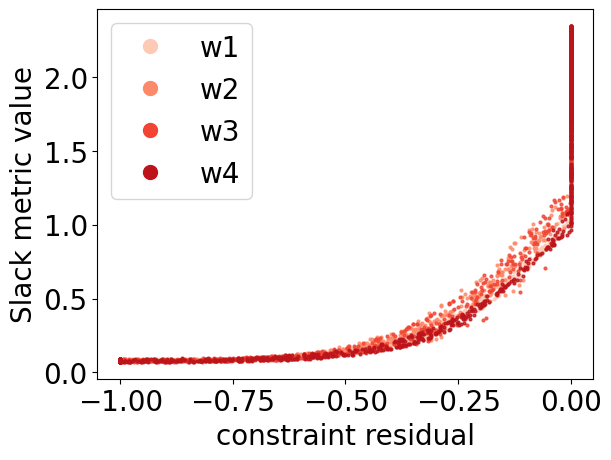

In [52]:

import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D
import numpy as np
import matplotlib.cm as cm

plt.rcParams.update({'font.size': 20})

colors = cm.Reds(np.linspace(0.2,0.8,4))
# Create figure and plot the data
fig, ax = plt.subplots()
ax.plot(cr[:,0], pv[:,0], '.', label='w1', alpha=0.8,color = colors[0],markersize = 4)
ax.plot(cr[:,1], pv[:,1], '.', label='w2', alpha=0.8,color = colors[1],markersize = 4)
ax.plot(cr[:,2], pv[:,2], '.', label='w3', alpha=0.8,color = colors[2],markersize = 4)
ax.plot(cr[:,3], pv[:,3], '.', label='w4', alpha=0.8,color = colors[3],markersize = 4)

def change_alpha(handle, original):
    ''' Change the alpha and marker style of the legend handles '''
    handle.update_from(original)
    handle.set_alpha(1)
    handle.set_marker('.')
    handle.set_markersize(20)

# Add the legend, and set the handler map to use the change_alpha function
ax.legend(handler_map={plt.Line2D: HandlerLine2D(update_func=change_alpha)})
ax.set_xlabel('constraint residual')
ax.set_ylabel('Slack metric value')
plt.show()

In [13]:
'''
Convergence Evaluation
'''
solver.num_steps = 30
p1 = -1.0
p2 = -1.0
test_p = torch.tensor([p1,p2],dtype=torch.float32)
test_x = torch.tensor([0.32,-0.37],dtype=torch.float32)

prob, x, y = QP_param(p1, p2)
prob.solve(solver='ECOS_BB', verbose=False)
prob.solve()
x_true = x.value
y_true = y.value


test_x = torch.unsqueeze(test_x,0)
test_p = torch.unsqueeze(test_p,0)

x_hist = solver(test_x,test_p)[2]
x_hist = torch.stack(x_hist).detach().numpy()
x_hist = x_hist[:,0,0:2]

#np.save('Convergence_Data/pqpDRIdentity.npy',x_hist)